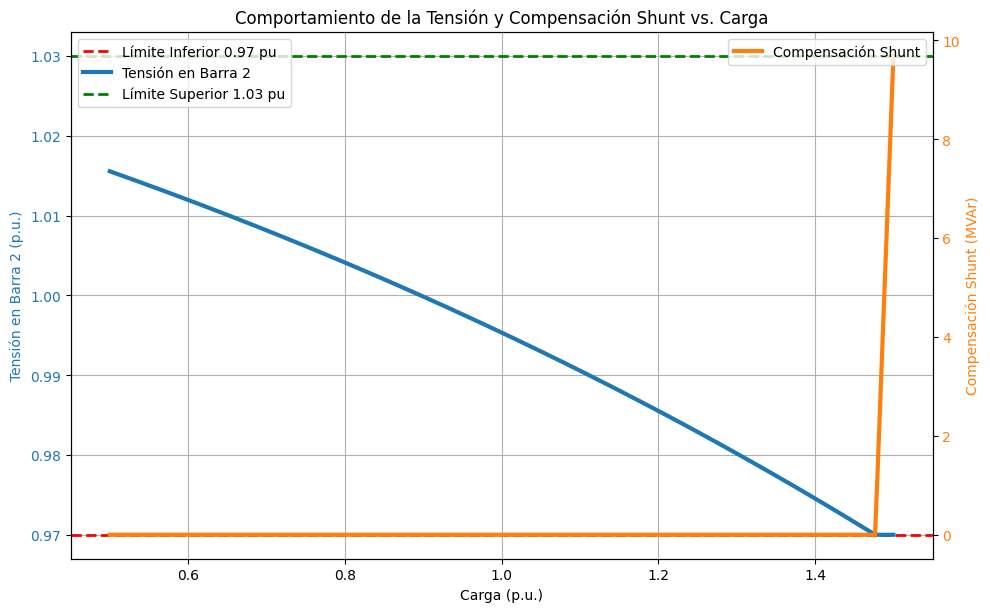

In [2]:
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np

# Red de referencia
net = pp.create_empty_network()

# Barras
bus1 = pp.create_bus(net, vn_kv=500, name="Bus 1")
bus2 = pp.create_bus(net, vn_kv=500, name="Bus 2")

# Datos de la línea
length_km = 500  
r_ohm_per_km = 0.02  
x_ohm_per_km = 0.115
c_nf_per_km = 19.1  
max_i_ka = 1

# Líneas de transmisión
pp.create_line_from_parameters(net, from_bus=bus1, to_bus=bus2, length_km=length_km,
                               r_ohm_per_km=r_ohm_per_km, x_ohm_per_km=x_ohm_per_km,
                               c_nf_per_km=c_nf_per_km, max_i_ka=max_i_ka, name='Línea 1')
pp.create_line_from_parameters(net, from_bus=bus1, to_bus=bus2, length_km=length_km,
                               r_ohm_per_km=r_ohm_per_km, x_ohm_per_km=x_ohm_per_km,
                               c_nf_per_km=c_nf_per_km, max_i_ka=max_i_ka, name='Línea 2')

# Barra slack
pp.create_ext_grid(net, bus=bus1, vm_pu=1.0)

# Carga nominal
p_nominal = 1080  # MW
q_nominal = 523.068  # MVAr

# Rango de carga ±50%
p_values = np.linspace(0.5 * p_nominal, 1.5 * p_nominal, 300)
voltages = []
compensations = []

# Simular para cada valor de carga
for p in p_values:
    pp.create_load(net, bus=bus2, p_mw=p, q_mvar=q_nominal)
    pp.runpp(net)
    
    # Compensación shunt necesaria
    vm = net.res_bus.vm_pu[bus2]
    q_shunt = 0
    tolerance = 0.001  # Tolerancia para iteraciones
    max_iterations = 100  # Número máximo de iteraciones
    iteration = 0
    
    while (vm < 0.97 or vm > 1.03) and iteration < max_iterations:
        if vm < 0.97:
            q_shunt += (0.97 - vm) * p_nominal  # Compensar con reactancia inductiva
        elif vm > 1.03:
            q_shunt -= (vm - 1.03) * p_nominal  # Compensar con reactancia capacitiva
        
        # Agregar la compensación shunt
        if q_shunt != 0:
            pp.create_sgen(net, bus=bus2, p_mw=0, q_mvar=q_shunt)
            pp.runpp(net)
            vm = net.res_bus.vm_pu[bus2]
            net.sgen.drop(net.sgen.index, inplace=True)  # Resetear la compensación shunt
        
        iteration += 1
    
    voltages.append(vm)
    compensations.append(q_shunt)
    
    net.load.drop(net.load.index, inplace=True)  # Resetear las cargas para la próxima simulación

# Graficar los resultados
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Carga (p.u.)')
ax1.set_ylabel('Tensión en Barra 2 (p.u.)', color=color)
ax1.axhline(y=0.97, color='r', linestyle='--', label='Límite Inferior 0.97 pu', linewidth=2)
ax1.plot(p_values / p_nominal, voltages, '-', label="Tensión en Barra 2", color=color, linewidth=3)

ax1.axhline(y=1.03, color='g', linestyle='--', label='Límite Superior 1.03 pu', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.grid()

ax2 = ax1.twinx()  # Instancia del segundo eje que comparte el mismo eje x
color = 'tab:orange'
ax2.set_ylabel('Compensación Shunt (MVAr)', color=color)
ax2.plot(p_values / p_nominal, compensations, '-', label="Compensación Shunt", color=color, linewidth=3)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()  # Para un ajuste adecuado del layout
plt.title('Comportamiento de la Tensión y Compensación Shunt vs. Carga')
plt.show()